# Removing the column with the highest p-value

In [2]:
library(lubridate)  #work with dates
library(xts)
library(forecast)
lct <- Sys.getlocale("LC_TIME"); Sys.setlocale("LC_TIME", "C") #needed for as.POSIXct


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



[1] "C"

In [3]:
data <- read.csv('bicup2006.csv',sep=',')
head(data)
dim(data)

DATE,TIME,DEMAND
1-Mar-05,6:30,1
1-Mar-05,6:45,2
1-Mar-05,7:00,4
1-Mar-05,7:15,0
1-Mar-05,7:30,10
1-Mar-05,7:45,13


[1] 1512    3

In [4]:
daytype<-rep("weekday",1512)
daytype[253:378]<-"weekend"
daytype[694:819]<-"weekend"
daytype[1135:1260]<-"weekend"
dtype<-rep(1,1512)
dtype[which(daytype=="weekend")]<-3


myseason<-rep(seq(1,63),24)

In [5]:
date.and.time<-paste(data$DATE,data$TIME) #combine date and time in one column
posix.date<-as.POSIXct(date.and.time,format="%d-%b-%y %H:%M")
#create new dataframe with columns posix.date and demand
newdata<-data.frame(posix.date,data$DEMAND,daytype,myseason,dtype)
names(newdata)<-c('date.and.time','demand','daytype','myseason','dtype')
head(newdata)
dim(newdata)

date.and.time,demand,daytype,myseason,dtype
2005-03-01 06:30:00,1,weekday,1,1
2005-03-01 06:45:00,2,weekday,2,1
2005-03-01 07:00:00,4,weekday,3,1
2005-03-01 07:15:00,0,weekday,4,1
2005-03-01 07:30:00,10,weekday,5,1
2005-03-01 07:45:00,13,weekday,6,1


[1] 1512    5

In [6]:
#indexes for first two weeks
training.set<-newdata[1:(14*63),]
#indexes for last week
validation.set<-newdata[((14*63)+1):(21*63),]
#indexes for last 3 days
future.set<-newdata[((21*63)+1):dim(newdata)[1],]

In [7]:
newdata.xts = xts(coredata(newdata$demand), order.by=as.POSIXct(newdata$date.and.time))
attr(newdata.xts,"frequency")<-63
periodicity(newdata.xts)
total_timeseries<-as.ts(newdata.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-24 22:00:00 

In [8]:
day_column<-rep(1,1512)
for(i in seq(1:1512)){
    
        day<-strtoi(substr(newdata$date.and.time[i],9,10),base = 10)
        if(day==7 | day==14 | day==21){
            day_column[i]<-1
        }else if(day==1 | day==8 | day==15 | day==22){
            day_column[i]<-2
        }else if(day==2 | day==9 | day==16 | day==23){
            day_column[i]<-3
        }else if(day==3 | day==10 | day==17 | day==24){
            day_column[i]<-4
        }else if(day==4 | day==11 | day==18 | day==25){
            day_column[i]<-5
        }else if(day==5 | day==12 | day==19 | day==26){
            day_column[i]<-6
        }else if(day==6 | day==13 | day==20){
            day_column[i]<-7
        }
}
            

In [30]:
seasonal_data<-data.frame(newdata,seasonaldummy(total_timeseries))



#dataframe used to represent our model.The columns are the variables.
model.data<-data.frame(seasonal_data$demand, seasonal_data$dtype, day_column, seasonal_data[6:67]
,seasonal_data$dtype*seasonal_data[6:67], day_column*seasonal_data[6:67]
,seasonal_data$dtype*day_column*seasonal_data[6:67])

colnames(model.data)<-c('demand','daytype','daynumber',colnames(model.data)[4:65],
                        paste(colnames(model.data)[4:65],'.dtype',sep = ''),
                        paste(colnames(model.data)[4:65],'.day',sep = ''),
                        paste(colnames(model.data)[4:65],'.day.dtype',sep = ''))

trainingdata<-model.data[1:882,]


head(model.data)
dim(model.data)
names(model.data)

demand,daytype,daynumber,S1,S2,S3,S4,S5,S6,S7,...,S53.day.dtype,S54.day.dtype,S55.day.dtype,S56.day.dtype,S57.day.dtype,S58.day.dtype,S59.day.dtype,S60.day.dtype,S61.day.dtype,S62.day.dtype
1,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


[1] 1512  251

[1] "demand"        "daytype"       "daynumber"     "S1"           
  [5] "S2"            "S3"            "S4"            "S5"           
  [9] "S6"            "S7"            "S8"            "S9"           
 [13] "S10"           "S11"           "S12"           "S13"          
 [17] "S14"           "S15"           "S16"           "S17"          
 [21] "S18"           "S19"           "S20"           "S21"          
 [25] "S22"           "S23"           "S24"           "S25"          
 [29] "S26"           "S27"           "S28"           "S29"          
 [33] "S30"           "S31"           "S32"           "S33"          
 [37] "S34"           "S35"           "S36"           "S37"          
 [41] "S38"           "S39"           "S40"           "S41"          
 [45] "S42"           "S43"           "S44"           "S45"          
 [49] "S46"           "S47"           "S48"           "S49"          
 [53] "S50"           "S51"           "S52"           "S53"          
 [57] "S54"           "S55"           "S56"           "S57"          
 [61] "S58"           "S59"           "S60"           "S61"          
 [65] "S62"           "S1.dtype"      "S2.dtype"      "S3.dtype"     
 [69] "S4.dtype"      "S5.dtype"      "S6.dtype"      "S7.dtype"     
 [73] "S8.dtype"      "S9.dtype"      "S10.dtype"     "S11.dtype"    
 [77] "S12.dtype"     "S13.dtype"     "S14.dtype"     "S15.dtype"    
 [81] "S16.dtype"     "S17.dtype"     "S18.dtype"     "S19.dtype"    
 [85] "S20.dtype"     "S21.dtype"     "S22.dtype"     "S23.dtype"    
 [89] "S24.dtype"     "S25.dtype"     "S26.dtype"     "S27.dtype"    
 [93] "S28.dtype"     "S29.dtype"     "S30.dtype"     "S31.dtype"    
 [97] "S32.dtype"     "S33.dtype"     "S34.dtype"     "S35.dtype"    
[101] "S36.dtype"     "S37.dtype"     "S38.dtype"     "S39.dtype"    
[105] "S40.dtype"     "S41.dtype"     "S42.dtype"     "S43.dtype"    
[109] "S44.dtype"     "S45.dtype"     "S46.dtype"     "S47.dtype"    
[113] "S48.dtype"     "S49.dtype"     "S50.dtype"     "S51.dtype"    
[117] "S52.dtype"     "S53.dtype"     "S54.dtype"     "S55.dtype"    
[121] "S56.dtype"     "S57.dtype"     "S58.dtype"     "S59.dtype"    
[125] "S60.dtype"     "S61.dtype"     "S62.dtype"     "S1.day"       
[129] "S2.day"        "S3.day"        "S4.day"        "S5.day"       
[133] "S6.day"        "S7.day"        "S8.day"        "S9.day"       
[137] "S10.day"       "S11.day"       "S12.day"       "S13.day"      
[141] "S14.day"       "S15.day"       "S16.day"       "S17.day"      
[145] "S18.day"       "S19.day"       "S20.day"       "S21.day"      
[149] "S22.day"       "S23.day"       "S24.day"       "S25.day"      
[153] "S26.day"       "S27.day"       "S28.day"       "S29.day"      
[157] "S30.day"       "S31.day"       "S32.day"       "S33.day"      
[161] "S34.day"       "S35.day"       "S36.day"       "S37.day"      
[165] "S38.day"       "S39.day"       "S40.day"       "S41.day"      
[169] "S42.day"       "S43.day"       "S44.day"       "S45.day"      
[173] "S46.day"       "S47.day"       "S48.day"       "S49.day"      
[177] "S50.day"       "S51.day"       "S52.day"       "S53.day"      
[181] "S54.day"       "S55.day"       "S56.day"       "S57.day"      
[185] "S58.day"       "S59.day"       "S60.day"       "S61.day"      
[189] "S62.day"       "S1.day.dtype"  "S2.day.dtype"  "S3.day.dtype" 
[193] "S4.day.dtype"  "S5.day.dtype"  "S6.day.dtype"  "S7.day.dtype" 
[197] "S8.day.dtype"  "S9.day.dtype"  "S10.day.dtype" "S11.day.dtype"
[201] "S12.day.dtype" "S13.day.dtype" "S14.day.dtype" "S15.day.dtype"
[205] "S16.day.dtype" "S17.day.dtype" "S18.day.dtype" "S19.day.dtype"
[209] "S20.day.dtype" "S21.day.dtype" "S22.day.dtype" "S23.day.dtype"
[213] "S24.day.dtype" "S25.day.dtype" "S26.day.dtype" "S27.day.dtype"
[217] "S28.day.dtype" "S29.day.dtype" "S30.day.dtype" "S31.day.dtype"
[221] "S32.day.dtype" "S33.day.dtype" "S34.day.dtype" "S35.day.dtype"
[225] "S36.day.dtype" "S37.day.dtype" "S38.day.dtype" "S39.day.dtype"
[229] "S40.d

In [31]:
model<-lm(demand~.,trainingdata)

summary(model)


Call:
lm(formula = demand ~ ., data = trainingdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.400  -2.038   0.000   2.000  26.650 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     9.44286    3.80241   2.483  0.01327 *  
daytype        -1.60000    3.05316  -0.524  0.60043    
daynumber      -0.71429    1.37928  -0.518  0.60473    
S1             -7.69286   22.09913  -0.348  0.72788    
S2             -8.36786   22.09913  -0.379  0.70507    
S3             -9.84286   22.09913  -0.445  0.65619    
S4             -2.04286   22.09913  -0.092  0.92638    
S5              0.75714   22.09913   0.034  0.97268    
S6             10.93214   22.09913   0.495  0.62099    
S7             14.45714   22.09913   0.654  0.51322    
S8             17.90714   22.09913   0.810  0.41807    
S9              6.90714   22.09913   0.313  0.75472    
S10            16.00714   22.09913   0.724  0.46913    
S11            12.38214   22.09913   0.560  0.57547   

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

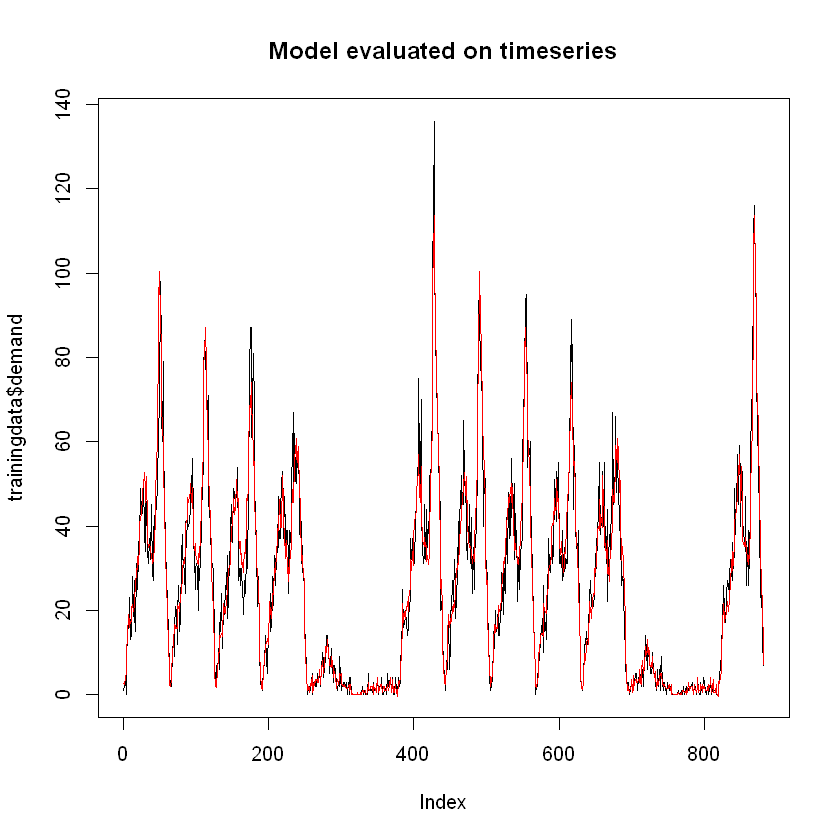

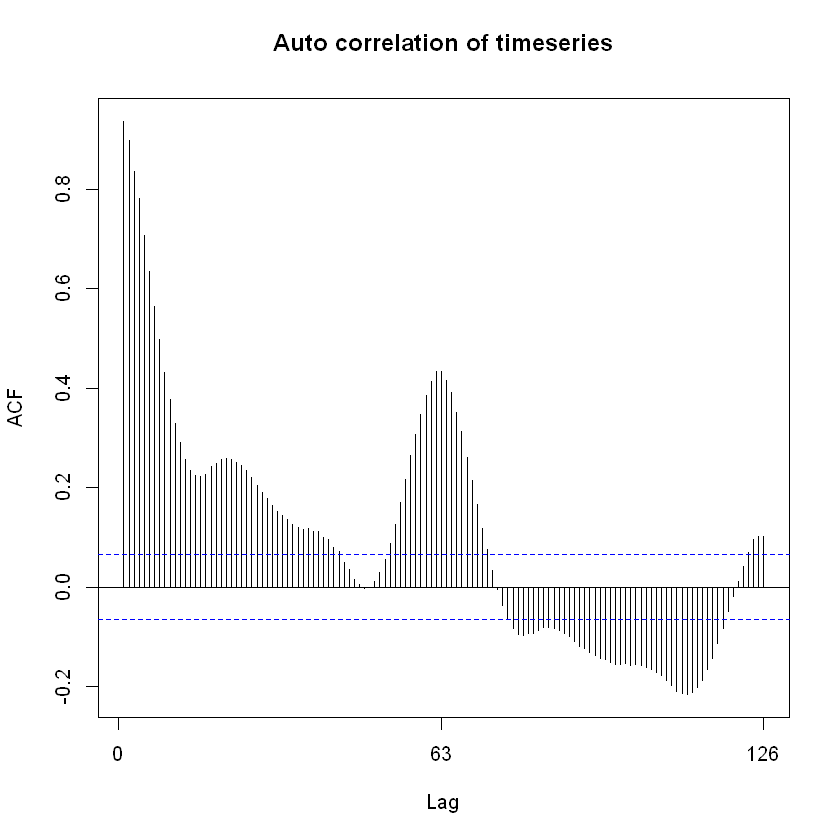

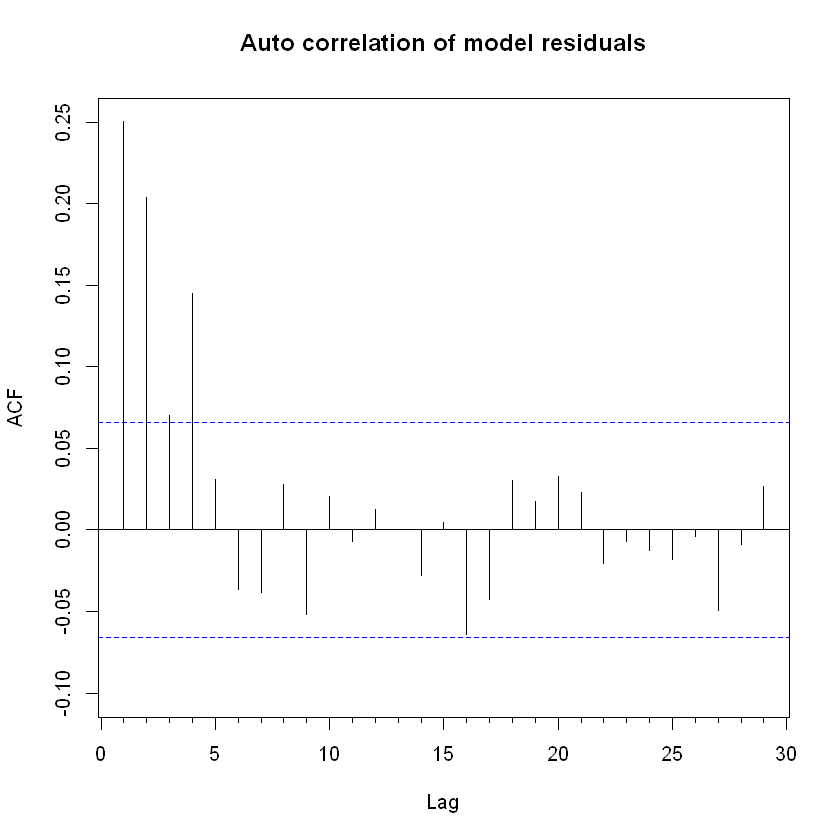

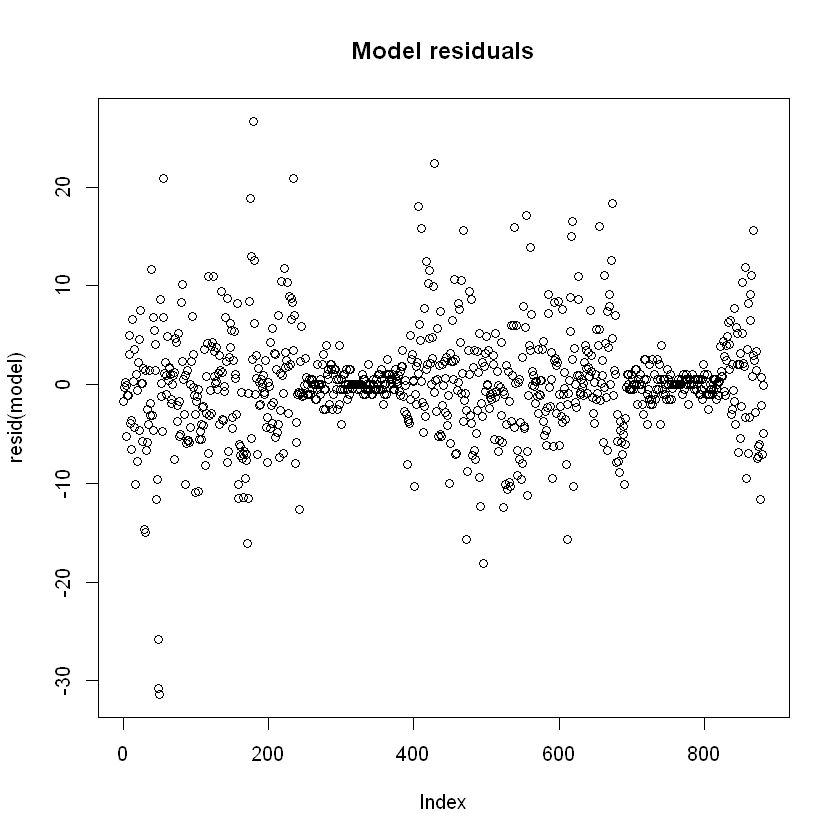

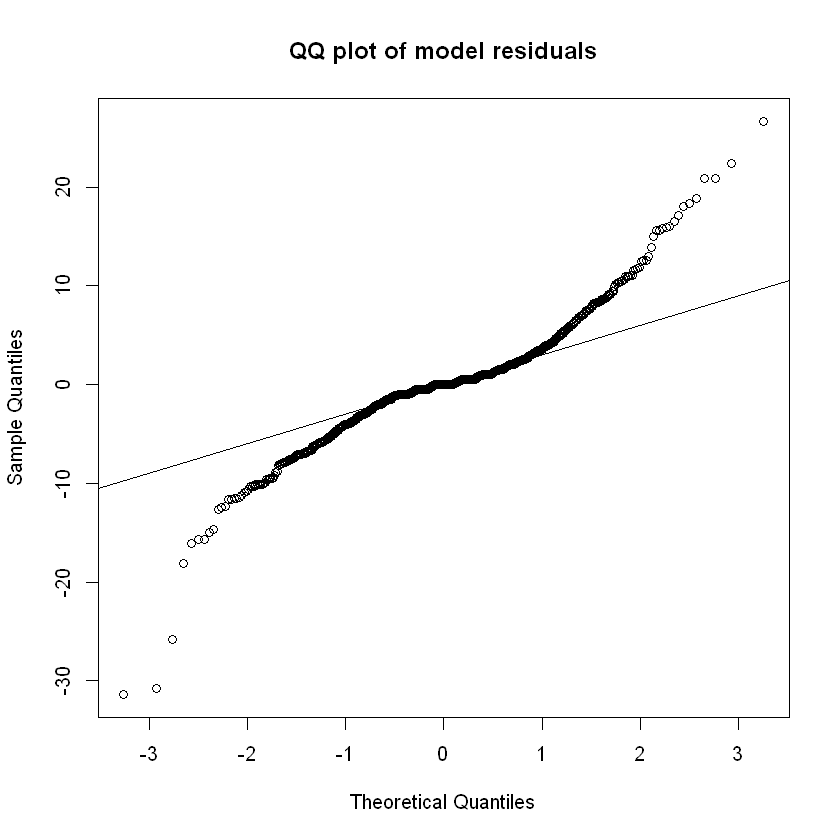

In [32]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries<-as.ts(my.xts)



#coefficients(model)
coef<-coefficients(model)
plot(trainingdata$demand,main='Model evaluated on timeseries',type='l')
lines(model$fitted, lwd = 1,col='red')

#model testing
Acf(timeseries,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

In [12]:
#We create a new dataframe to make the model calculation easier below
ones<-rep(1,1512)
#we remove the demand column since thats what we predict and we replace it with ones
#so they are multiplied by the intercept coefficient
final.model.data<-data.frame(ones,model.data[,-1])


head(final.model.data)
dim(final.model.data)

ones,daytype,daynumber,S1,S2,S3,S4,S5,S6,S7,...,S53.day.dtype,S54.day.dtype,S55.day.dtype,S56.day.dtype,S57.day.dtype,S58.day.dtype,S59.day.dtype,S60.day.dtype,S61.day.dtype,S62.day.dtype
1,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


[1] 1512  251

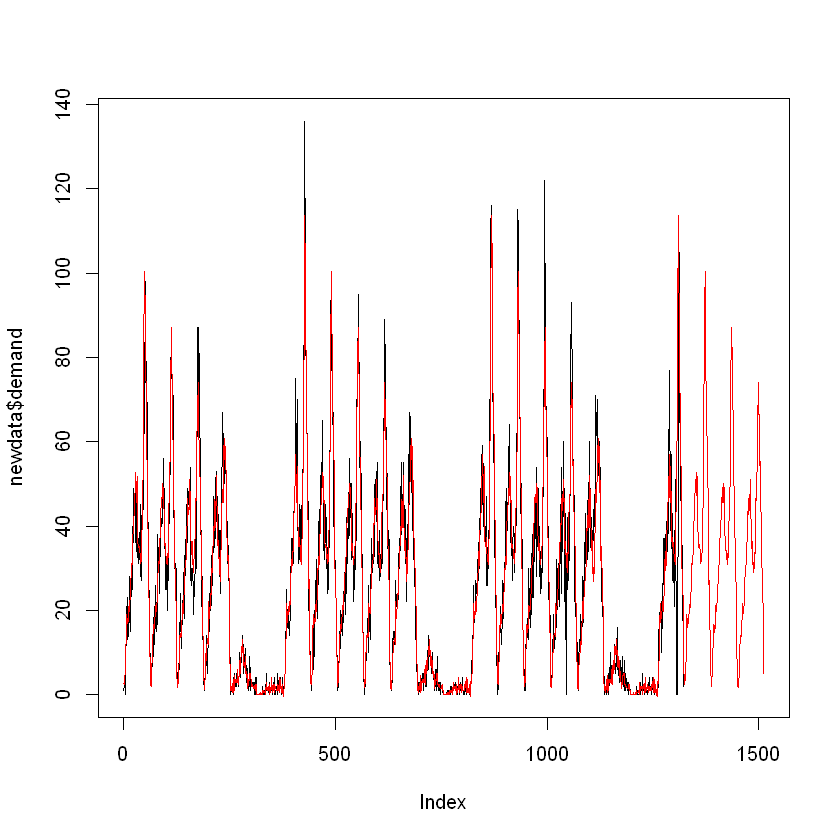

In [13]:
#coefficients(model)
coef<-coefficients(model)

mymodel = rowSums(mapply("*", as.data.frame(final.model.data),coef))

plot(newdata$demand,type='l')
lines(mymodel,lwd = 1,col='red')

In [14]:
actual.demand<-validation.set$demand
predicted.demand<-mymodel[883:1323]

residuals<-actual.demand-predicted.demand

#Adjusted R-Squared
n=length(actual.demand)
k=dim(final.model.data)[2]-1 #Subtract one to ignore intercept
SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
1-(SSE/SSyy)*(n-1)/(n-(k+1))


[1] 0.6170806

In [15]:
head(coef(summary(model)))
#coef(summary(model))[,'Pr(>|t|)']
maxpvalue<-max(coef(summary(model))[,'Pr(>|t|)'])
maxpvalue

#row.names(coef(summary(model)))
maxindex<-which(coef(summary(model))[,'Pr(>|t|)']==maxpvalue)
maxindex
nameofmaxp<-names(maxindex)
nameofmaxp

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),9.4428571,3.802406,2.4833903,0.01327246
daytype,-1.6000000,3.053161,-0.5240471,0.60042981
daynumber,-0.7142857,1.379277,-0.5178695,0.60473084
S1,-7.6928571,22.099128,-0.3481068,0.72787607
S2,-8.3678571,22.099128,-0.3786510,0.70507441
S3,-9.8428571,22.099128,-0.4453957,0.65618657


[1] 0.9978889

S37.day 
    164

[1] "S37.day"

Now lets remove that from our model and calculate everything again

In [16]:
new.model.data<-model.data[,-which(names(model.data)==nameofmaxp)]


trainingdata<-new.model.data[1:882,]

In [17]:
newmodel<-lm(demand~.,trainingdata)

summary(newmodel)


Call:
lm(formula = demand ~ ., data = trainingdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.400  -2.038   0.000   2.000  26.650 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     9.44441    3.75377   2.516 0.012117 *  
daytype        -1.59782    2.93797  -0.544 0.586734    
daynumber      -0.71553    1.29571  -0.552 0.580985    
S1             -7.69441   22.07383  -0.349 0.727524    
S2             -8.36941   22.07383  -0.379 0.704700    
S3             -9.84441   22.07383  -0.446 0.655767    
S4             -2.04441   22.07383  -0.093 0.926237    
S5              0.75559   22.07383   0.034 0.972705    
S6             10.93059   22.07383   0.495 0.620643    
S7             14.45559   22.07383   0.655 0.512787    
S8             17.90559   22.07383   0.811 0.417575    
S9              6.90559   22.07383   0.313 0.754505    
S10            16.00559   22.07383   0.725 0.468663    
S11            12.38059   22.07383   0.561 0.575084   

In [51]:
coefficients(newmodel)[1:59]

(Intercept)     daytype          S6          S7          S8          S9 
   8.227588   -2.993314   12.128600   18.985742   13.722412   12.850439 
        S10         S11         S12         S13         S14         S15 
  15.072412   16.985742   18.010496   17.972961   16.429051   17.365312 
        S16         S17         S18         S19         S20         S21 
  20.522181   22.413116   26.295198   28.086983   30.580255   29.476502 
        S22         S23         S24         S25         S26         S27 
  32.989249   40.173740   41.177989   41.974377   47.371332   46.868499 
        S28         S29         S30         S31         S32         S33 
  48.134434   50.180114   41.751617   46.267932   50.924094   39.134788 
        S34         S35         S36         S37         S38         S39 
  35.599023   32.747748   35.075652   32.200298   31.786346   36.572412 
        S40         S41         S42         S43         S44         S45 
  29.318215   41.022412   31.395057   25.655218   57.547412   59.522412 
        S46         S47         S48         S49         S50         S51 
  72.948602   77.547412  119.239079  166.622412  137.500983  121.253364 
        S52         S53         S54         S55         S56         S57 
 110.989079   89.031936   86.981936   76.498602   68.005745   57.600983 
        S58         S59         S60         S61         S62 
  40.497412   24.968357   30.947412   14.865666    4.476190

In [18]:
#We create a new dataframe to make the model calculation easier below
ones<-rep(1,1512)
#we remove the demand column since thats what we predict and we replace it with ones
#so they are multiplied by the intercept coefficient
new.final.model.data<-data.frame(ones,new.model.data[,-1])


#coefficients(model)
newcoef<-coefficients(newmodel)

newmymodel = rowSums(mapply("*", as.data.frame(new.final.model.data),newcoef))


actual.demand<-validation.set$demand
predicted.demand<-newmymodel[883:1323]

residuals<-actual.demand-predicted.demand

#Adjusted R-Squared
n=length(actual.demand)
k=dim(new.final.model.data)[2]-1 #Subtract one to ignore intercept
SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
1-(SSE/SSyy)*(n-1)/(n-(k+1))


[1] 0.6190841

In [19]:
#coef(summary(model))[,'Pr(>|t|)']
maxpvalue<-max(coef(summary(newmodel))[,'Pr(>|t|)'])
maxpvalue

#row.names(coef(summary(model)))
maxindex<-which(coef(summary(newmodel))[,'Pr(>|t|)']==maxpvalue)
maxindex
nameofmaxp<-names(maxindex)
nameofmaxp

[1] 0.9962717

S24.dtype 
       89

[1] "S24.dtype"

# Let's do the above steps in a loop

In [20]:
numloops<-200
R2<-rep(1,numloops)

for(i in seq(1:numloops)){
    
    
    maxpvalue<-max(coef(summary(newmodel))[,'Pr(>|t|)'])
    cat('\nNew max p-value: ',maxpvalue,'\t')
    
    if(maxpvalue < 0.05){
        cat('Trying to remove variable with p-value',maxpvalue)
        break
    }
    
    maxindex<-which(coef(summary(newmodel))[,'Pr(>|t|)']==maxpvalue)
    nameofmaxp<-names(maxindex)
    cat('Column to be removed: ',nameofmaxp,'\n')
    
    new.model.data<-new.model.data[,-which(names(new.model.data)==nameofmaxp)]

    newtrainingdata<-new.model.data[1:882,]

    newmodel<-lm(demand~.,newtrainingdata)

    #summary(newmodel)
    
    
    #We create a new dataframe to make the model calculation easier below
    ones<-rep(1,1512)
    #we remove the demand column since thats what we predict and we replace it with ones
    #so they are multiplied by the intercept coefficient
    new.final.model.data<-data.frame(ones,new.model.data[,-1])


    #coefficients(model)
    newcoef<-coefficients(newmodel)

    newmymodel = rowSums(mapply("*", as.data.frame(new.final.model.data),newcoef))


    actual.demand<-validation.set$demand
    predicted.demand<-newmymodel[883:1323]

    residuals<-actual.demand-predicted.demand

    #Adjusted R-Squared
    n=length(actual.demand)
    k=dim(new.final.model.data)[2]-1 #Subtract one to ignore intercept
    SSE=sum(residuals**2)
    SSyy=sum((actual.demand-mean(actual.demand))**2)
    R2[i]<- 1-(SSE/SSyy)*(n-1)/(n-(k+1))
    
    cat('new R squared = ',R2[i],'\n\n')
    
    
    comparisondata<-data.frame(newdata$date.and.time,newdata$demand,round(newmymodel),newdata$demand-round(newmymodel),newdata$daytype,newdata$myseason)
    colnames(comparisondata)<-c('date.and.time','demand','predicted','residual','daytype','season')

    comparison.validation<-data.frame(comparisondata[883:1323,],
            abs((comparisondata$demand-comparisondata$predicted)/comparisondata$demand*100)[883:1323],
            abs(comparisondata$demand-comparisondata$predicted)[883:1323])

    colnames(comparison.validation)<-c(colnames(comparison.validation)[1:6],'APE','AE')

    #fix for 0 demand values
    comparison.validation$APE[comparison.validation$demand==0]<- abs(comparison.validation$predicted[comparison.validation$demand==0])/0.5*100
   # head(comparison.validation)

    MAPE<-mean(comparison.validation$APE)
    cat('MAPE=',MAPE,'\n')
    MAE=mean(comparison.validation$AE)
    cat('MAE=',MAE)
    
    
}






New max p-value:  0.9962717 	Column to be removed:  S24.dtype 
new R squared =  0.6210676 

MAPE= 159.7101 
MAE= 5.378685
New max p-value:  0.9947027 	Column to be removed:  S37.dtype 
new R squared =  0.6230351 

MAPE= 160.9419 
MAE= 5.399093
New max p-value:  0.9938282 	Column to be removed:  S6.day.dtype 
new R squared =  0.6249776 

MAPE= 159.9363 
MAE= 5.387755
New max p-value:  0.9920571 	Column to be removed:  S16.dtype 
new R squared =  0.6269011 

MAPE= 158.2286 
MAE= 5.365079
New max p-value:  0.9883152 	Column to be removed:  S4.dtype 
new R squared =  0.6288046 

MAPE= 156.6921 
MAE= 5.365079
New max p-value:  0.9952352 	Column to be removed:  S4.day.dtype 
new R squared =  0.6306898 

MAPE= 158.0459 
MAE= 5.367347
New max p-value:  0.9876609 	Column to be removed:  S15.day 
new R squared =  0.632551 

MAPE= 159.3157 
MAE= 5.369615
New max p-value:  0.9831669 	Column to be removed:  S20.day 
new R squared =  0.6343927 

MAPE= 157.6485 
MAE= 5.367347
New max p-value:  0.978

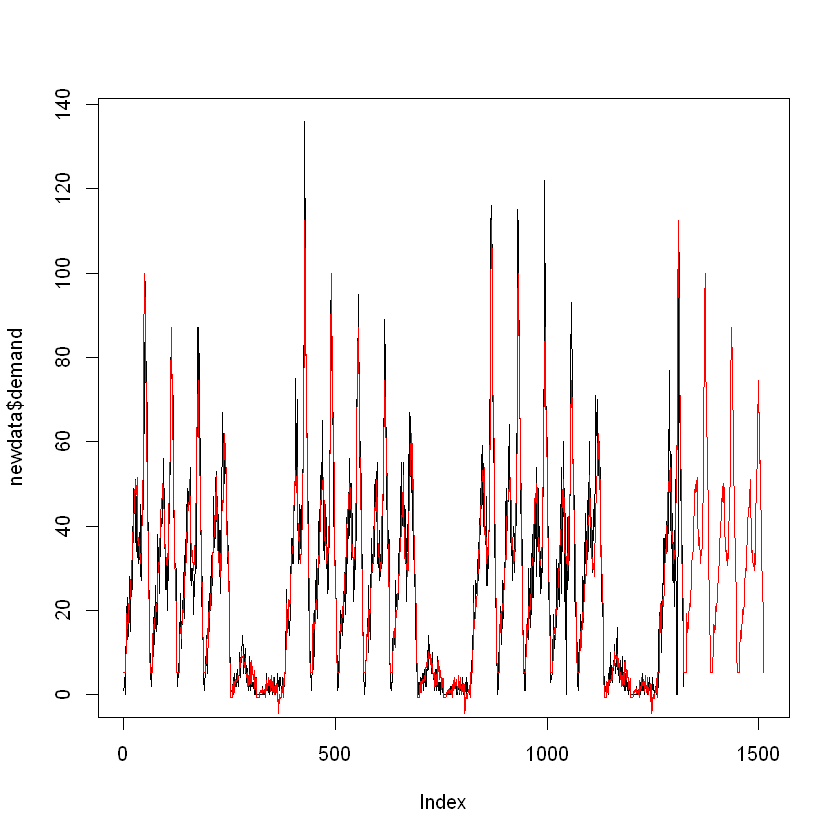

In [21]:
plot(newdata$demand,type='l')
lines(newmymodel,lwd = 1,col='red')

In [22]:
summary(newmodel)


Call:
lm(formula = demand ~ ., data = newtrainingdata)

Residuals:
     Min       1Q   Median       3Q      Max 
-30.8429  -2.8322  -0.2343   2.4918  26.2476 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     8.2276     1.1388   7.225 1.23e-12 ***
daytype        -2.9933     0.5898  -5.075 4.88e-07 ***
S6             12.1286     3.7800   3.209 0.001390 ** 
S7             18.9857     3.7800   5.023 6.37e-07 ***
S8             13.7224     3.4460   3.982 7.49e-05 ***
S9             12.8504     2.4622   5.219 2.33e-07 ***
S10            15.0724     3.4460   4.374 1.39e-05 ***
S11            16.9857     3.7800   4.494 8.10e-06 ***
S12            18.0105     2.4622   7.315 6.61e-13 ***
S13            17.9730     2.4622   7.300 7.35e-13 ***
S14            16.4291     2.4622   6.672 4.87e-11 ***
S15            17.3653     2.4622   7.053 3.98e-12 ***
S16            20.5222     2.4622   8.335 3.67e-16 ***
S17            22.4131     2.4622   9.103  < 2e-16 ***


In [23]:
#replace negative values with 0
final.model<-newmymodel
final.model[which(newmymodel<0)]<-0

In [24]:
actual.demand<-validation.set$demand
predicted.demand<-final.model[883:1323]

residuals<-actual.demand-predicted.demand


#Adjusted R-Squared
n=length(actual.demand)
k=dim(new.final.model.data)[2]-1 #Subtract one to ignore intercept
SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
R2.final<- 1-(SSE/SSyy)*(n-1)/(n-(k+1))

cat('final adjusted R squared on validation set = ',R2.final,'\n\n')

final adjusted R squared on validation set =  0.7664591 



Adjusted R squared increased from 0.617 to 0.766 with the removal of insignificant predictors.

What we can observe from the final coefficients is that for roughly the **first half of the seasons**, the interaction between **season and daytype** is insignificant.This means that the behavior of demand is roughly the same for the first half of the day regardless if its a weekday or weekend.Same goes for **day and season**.Meaning that we have the same behavior for the first half of the day regardless of what day it is.The difference happens mostly at the second half of the day which includes the high demand period(around 18:30). 

## First half of day

In [25]:
halfday<-with( seasonal_data , seasonal_data[ myseason <40 & !is.na(demand)  , ] )
dim(halfday)

[1] 819  67

In [26]:
weekdays<-with( halfday , halfday[ dtype==1 , ] )
dim(weekdays)

[1] 585  67

In [27]:
weekends<-with( halfday , halfday[ dtype==3 , ] )
dim(weekends)

[1] 234  67

In [28]:
saturdays<-seasonal_data[which(day_column==6),]
saturdays<-with( saturdays, saturdays[ myseason <40 & !is.na(demand)  , ] )

sundays<-seasonal_data[which(day_column==7),]
sundays<-with( sundays , sundays[ myseason <40 & !is.na(demand)  , ] )

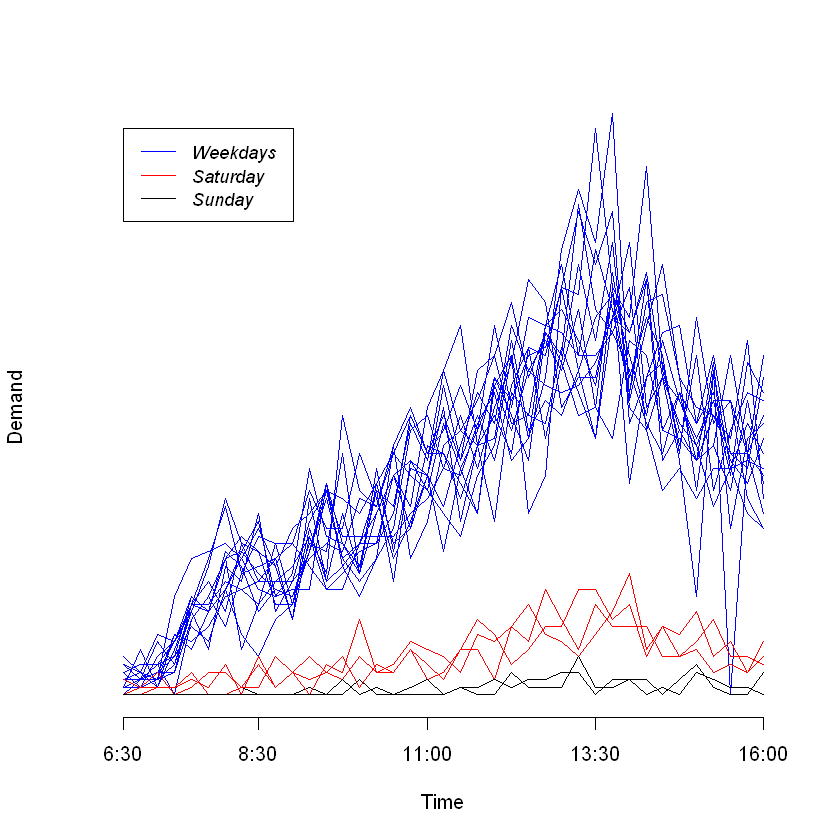

In [29]:
#every 39 rows it's a new day
start<-1
end<-start + 38
day.demand<-weekdays[start:end,'demand']
plot(day.demand,type='l',col='blue',ylim=c(0,76),axes=FALSE,xlab='Time',ylab='Demand')
#for x axis labels
axis(1,at=c(1,9,19,29,39),labels=c('6:30','8:30','11:00','13:30','16:00'))


while(end < 600){
    
    start<-end+1
    end<-start + 38
    
    day.demand<-weekdays[start:end,'demand']
    lines(day.demand,col='blue')  
}

#every 39 rows it's a new day
start<-1
end<-start + 38
day.demand<-weekends[start:end,'demand']
lines(day.demand,type='l',col='red',ylim=c(0,76))

while(end < 120){
    
    start<-end+1
    end<-start + 38
    
    day.demand<-saturdays[start:end,'demand']
    lines(day.demand,col='red') 
    day.demand<-sundays[start:end,'demand']
    lines(day.demand,col='black') 
    
}
legend(1, 75, legend=c("Weekdays", "Saturday","Sunday"),col=c( "blue","red","black"), lty=1:1, cex=0.9,text.font=3)


Blue lines tighter together which is why daynumber is insignificant here.Also pretty much same peaked behaviour on weekdays and weekends which is why daytype is insignificant here.

## End of day

In [38]:
endofday<-with( seasonal_data , seasonal_data[ myseason > 40 & myseason <63 & !is.na(demand) , ] )
dim(endofday)

[1] 462  67

In [39]:
weekdays<-with( endofday , endofday[ dtype==1 , ] )
dim(weekdays)

[1] 330  67

In [40]:
weekends<-with( endofday , endofday[ dtype==3 , ] )
dim(weekends)

[1] 132  67

In [43]:
saturdays<-seasonal_data[which(day_column==6),]
saturdays<-with( saturdays, saturdays[ myseason > 40 & myseason <63 & !is.na(demand)  , ] )

sundays<-seasonal_data[which(day_column==7),]
sundays<-with( sundays , sundays[ myseason > 40 & myseason <63 & !is.na(demand)  , ] )

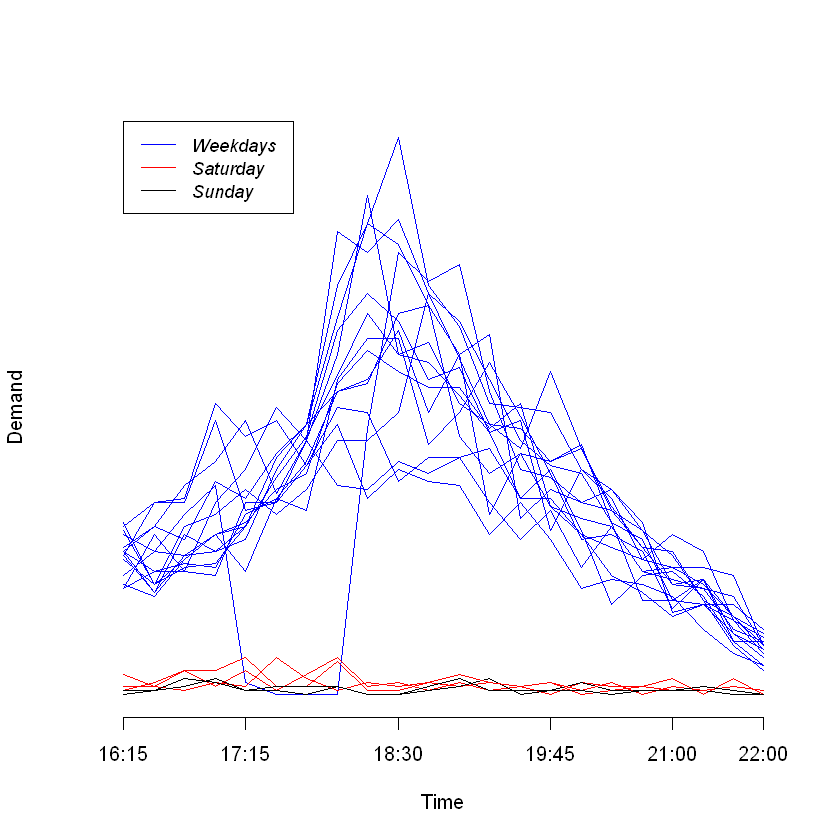

In [48]:
#every 21 rows it's a new day
start<-1
end<-start + 21
day.demand<-weekdays[start:end,'demand']
plot(day.demand,type='l',col='blue',ylim=c(0,140),axes=FALSE,xlab='Time',ylab='Demand')
#for x axis labels
axis(1,at=c(1,5,10,15,19,22),labels=c('16:15','17:15','18:30','19:45','21:00','22:00'))



while(end < 340){
    
    start<-end+1
    end<-start + 21
    
    day.demand<-weekdays[start:end,'demand']
    lines(day.demand,col='blue')  
}

#every 39 rows it's a new day
start<-1
end<-start + 21
day.demand<-weekends[start:end,'demand']
lines(day.demand,type='l',col='red',ylim=c(0,76))

while(end < 140){
    
    start<-end+1
    end<-start + 21
    
    day.demand<-saturdays[start:end,'demand']
    lines(day.demand,col='red') 
    day.demand<-sundays[start:end,'demand']
    lines(day.demand,col='black') 
    
}
legend(1, 140, legend=c("Weekdays", "Saturday","Sunday"),col=c( "blue","red","black"), lty=1:1, cex=0.9,text.font=3)



While on these seasons, lines are far less tight together which is why daynumber is significant.Also there is a different pattern on weekdays than on weekends which is why daytype is significant.

# Final model MAPE and MAE for training and validation periods

In [25]:
comparisondata<-data.frame(newdata$date.and.time,newdata$demand,round(final.model),newdata$demand-round(final.model),newdata$daytype,newdata$myseason)
colnames(comparisondata)<-c('date.and.time','demand','predicted','residual','daytype','season')

comparison.validation<-data.frame(comparisondata[883:1323,],
        abs((comparisondata$demand-comparisondata$predicted)/comparisondata$demand*100)[883:1323],
        abs(comparisondata$demand-comparisondata$predicted)[883:1323])

colnames(comparison.validation)<-c(colnames(comparison.validation)[1:6],'APE','AE')

#fix for 0 demand values
comparison.validation$APE[comparison.validation$demand==0]<- abs(comparison.validation$predicted[comparison.validation$demand==0])/0.5*100
head(comparison.validation)

MAPE<-mean(comparison.validation$APE)
cat('MAPE=',MAPE,'\n')
MAE=mean(comparison.validation$AE)
cat('MAE=',MAE)

,date.and.time,demand,predicted,residual,daytype,season,APE,AE
883,2005-03-15 06:30:00,0,5,-5,weekday,1,1000.00000,5
884,2005-03-15 06:45:00,2,5,-3,weekday,2,150.00000,3
885,2005-03-15 07:00:00,4,5,-1,weekday,3,25.00000,1
886,2005-03-15 07:15:00,7,5,2,weekday,4,28.57143,2
887,2005-03-15 07:30:00,13,5,8,weekday,5,61.53846,8
888,2005-03-15 07:45:00,11,14,-3,weekday,6,27.27273,3


MAPE= 166.4575 
MAE= 5.478458

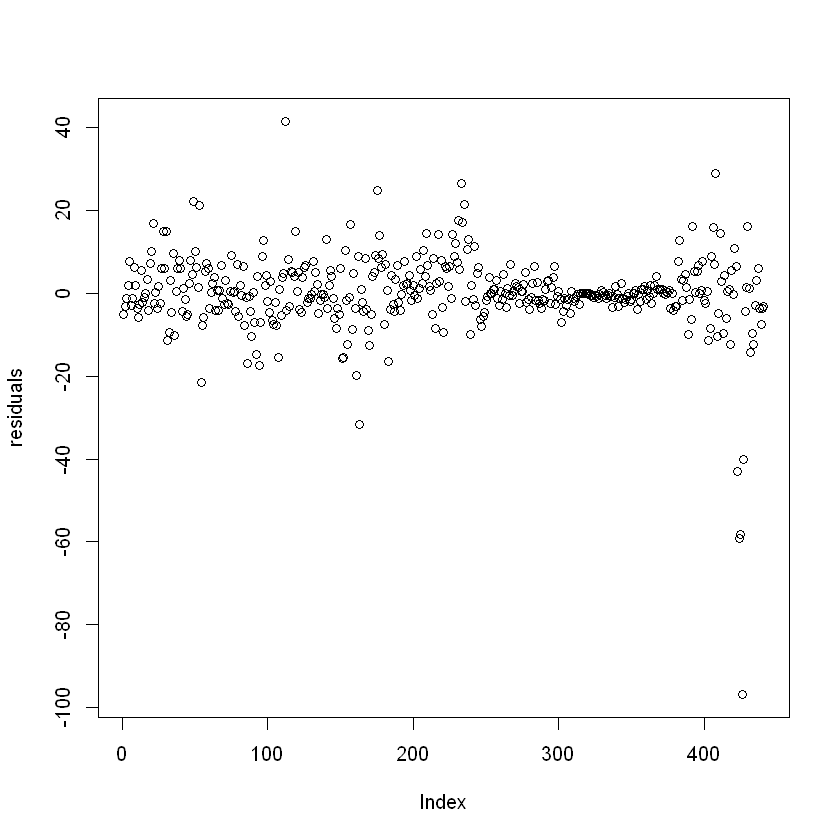

In [26]:
plot(residuals)

In [27]:
comparison.train<-data.frame(comparisondata[1:882,],
        abs((comparisondata$demand-comparisondata$predicted)/comparisondata$demand*100)[1:882],
        abs(comparisondata$demand-comparisondata$predicted)[1:882])

colnames(comparison.train)<-c(colnames(comparison.train)[1:6],'APE','AE')

#fix for 0 demand values
comparison.train$APE[comparison.train$demand==0]<- abs(comparison.train$predicted[comparison.train$demand==0])/0.5*100

MAPE<-mean(comparison.train$APE)
cat('MAPE=',MAPE,'\n')
MAE=mean(comparison.train$AE)
cat('MAE=',MAE)

MAPE= 46.39436 
MAE= 3.8322

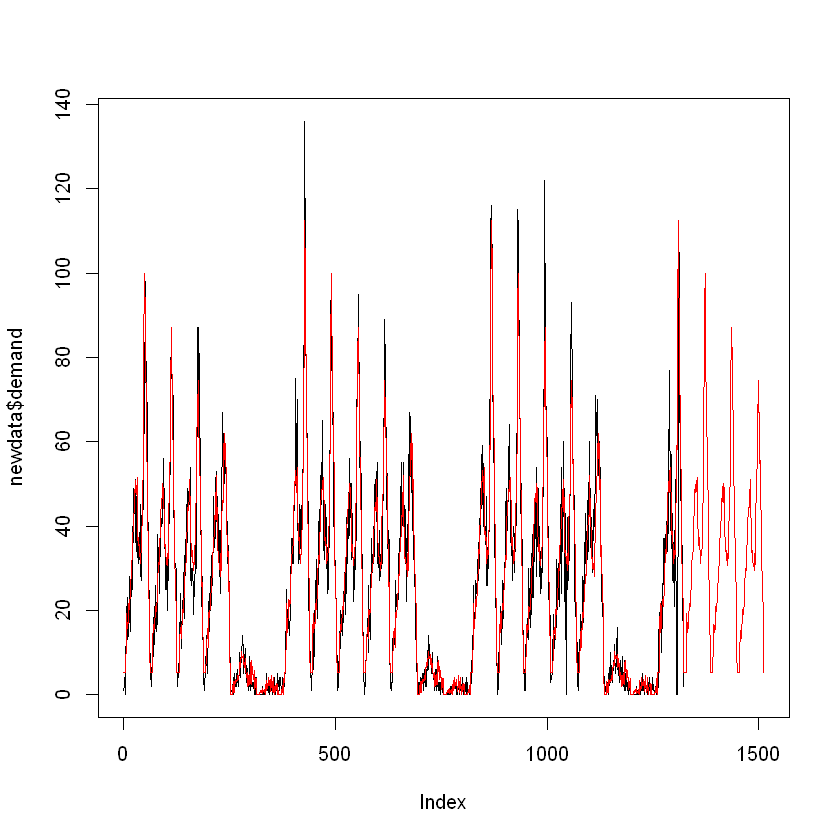

In [28]:
plot(newdata$demand,type='l')
lines(final.model,lwd = 1,col='red')

## Lets try arima errors

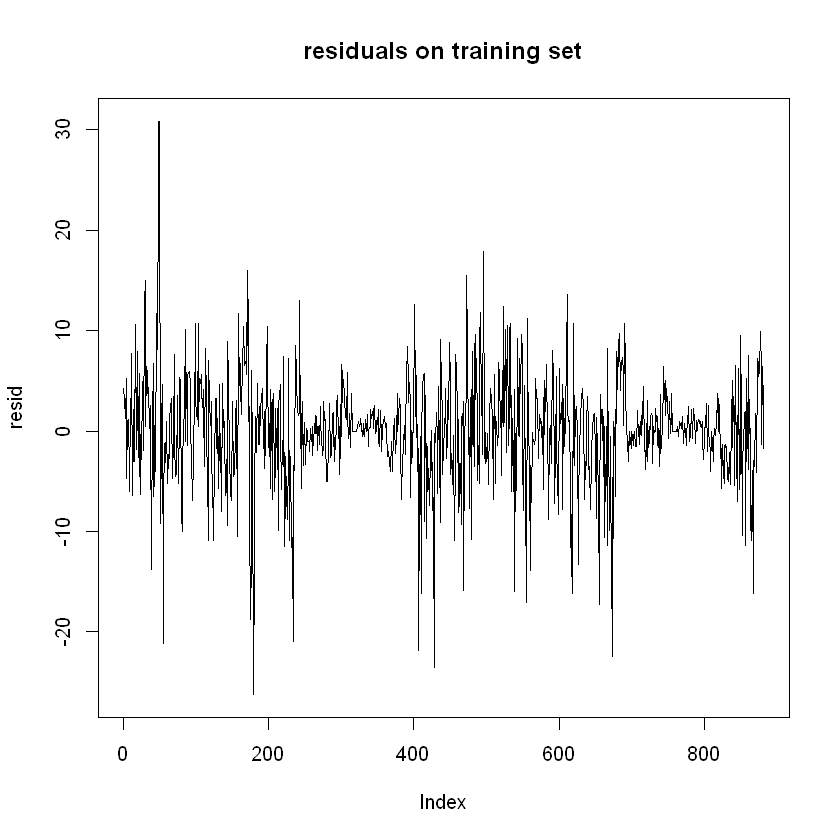

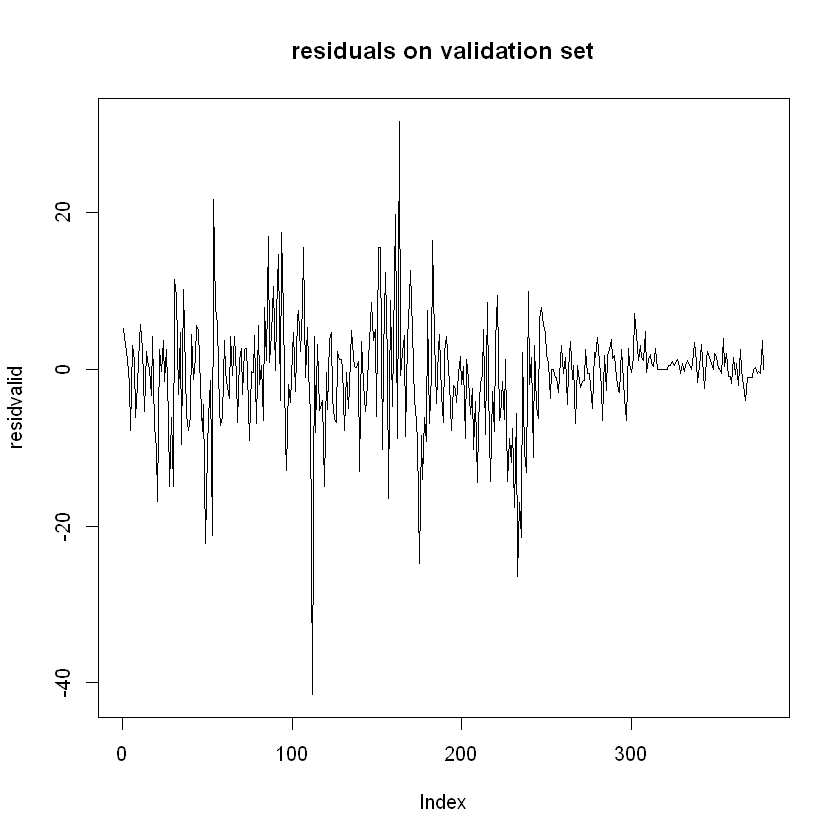

In [25]:
resid<-final.model[1:882]-training.set$demand
plot(resid,type='l',main='residuals on training set')
residseries<-ts(resid,frequency=63*7)

residvalid<-final.model[883:(882 +63*6)]-validation.set$demand[1:(63*6)]
plot(residvalid,type='l',main='residuals on validation set')

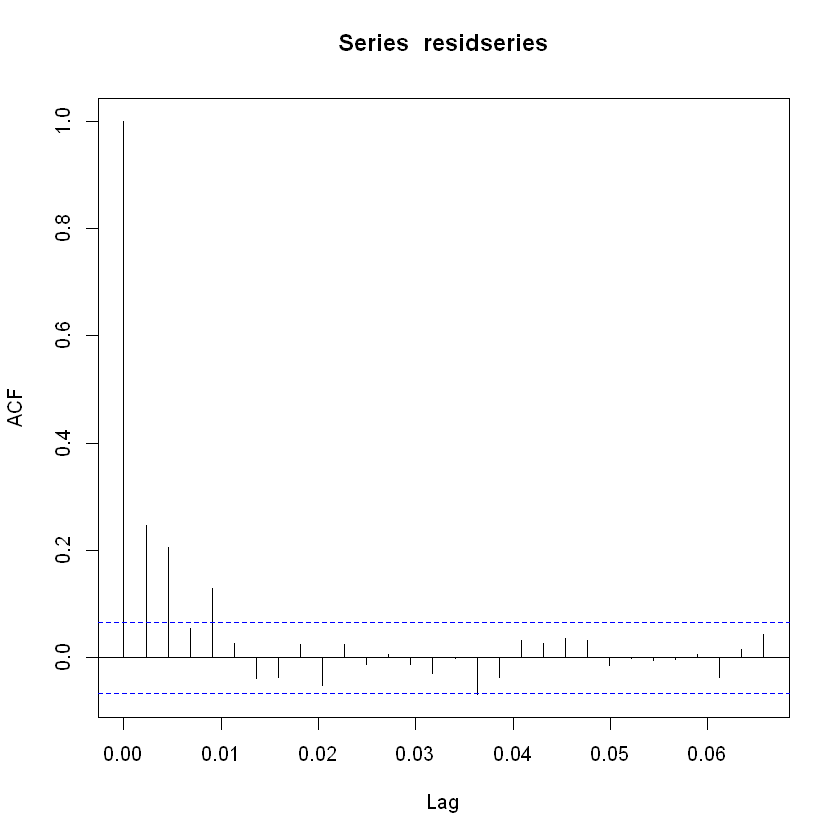

In [25]:
acf(residseries)

### my own arima

In [73]:
fit<-arima(residseries,c(2,0,3),seasonal = list(order = c(0,1,0), period = 441))

In [74]:
pred<-predict(fit,n.ahead = 63*7) #14 day prediction
pred1<-pred$pred

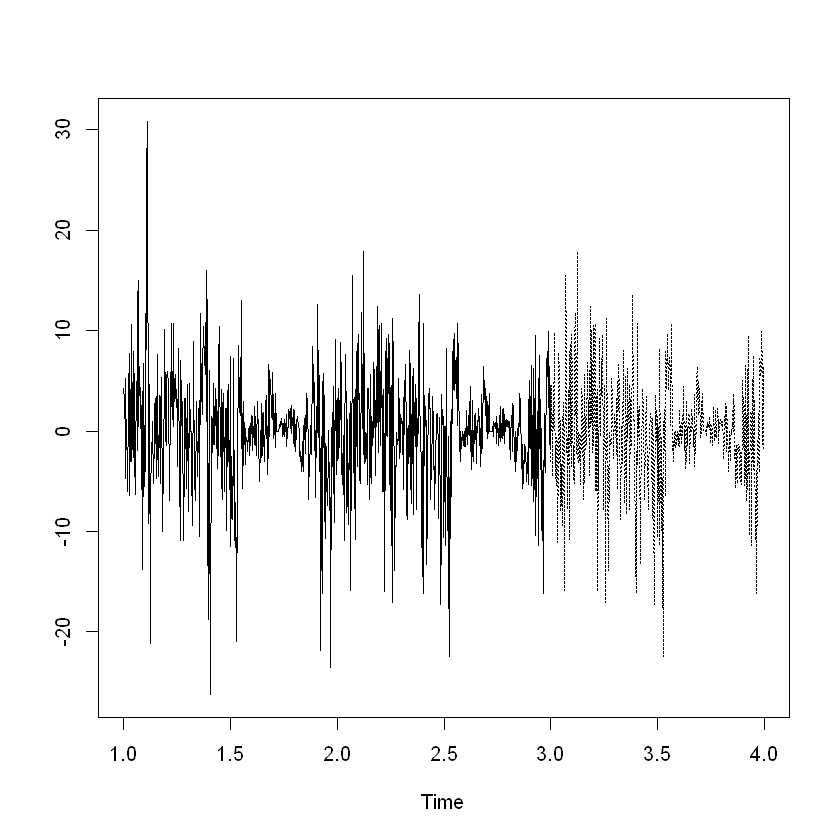

In [75]:
ts.plot(residseries,pred1,lty=c(1,3))

### Alex arima

In [76]:
tmp.fit.arima <- Arima(residseries, order=c(1,0,0))
#tmp.pred.arima<- forecast(train.res.arima, h=441)

In [77]:
pred<-predict(tmp.fit.arima,n.ahead = 63*7) #14 day prediction
pred1<-pred$pred

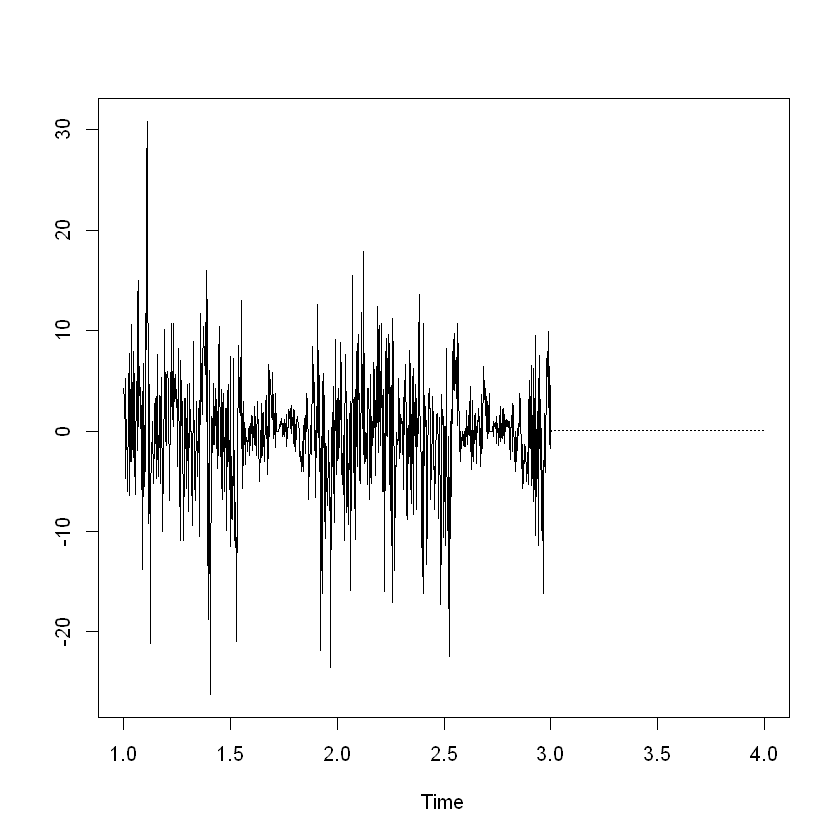

In [78]:
ts.plot(residseries,pred1,lty=c(1,3))

In [35]:
model<-auto.arima(ts(resid,frequency=63*7),D=1)

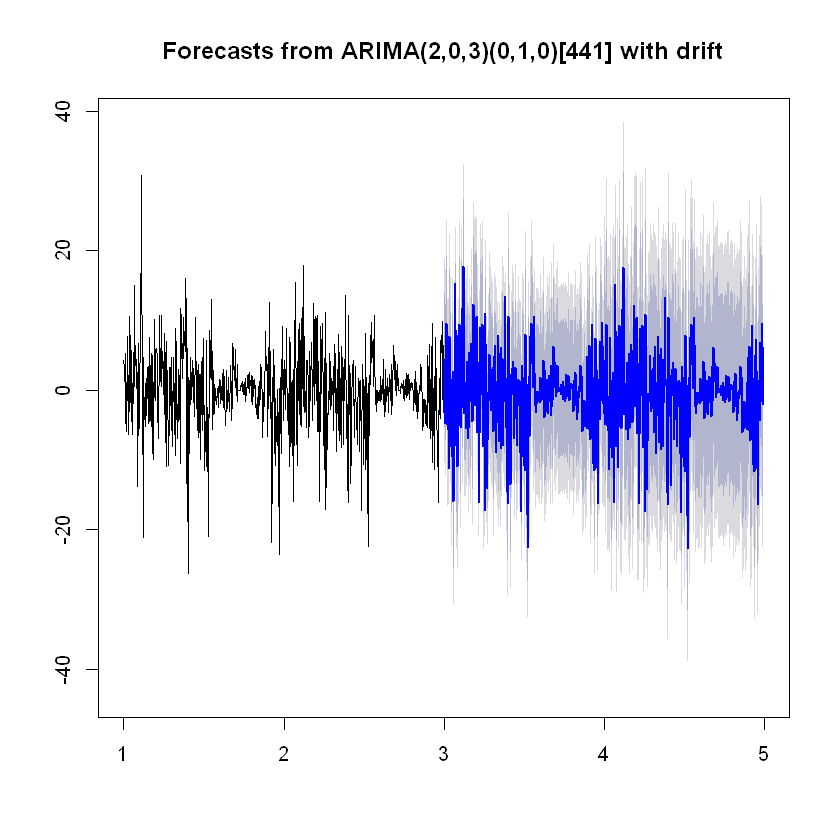

In [36]:
myforecast<-forecast(model)
#myforecast<-forecast(auto.arima(ts(resid,frequency=63*7),D=1),h=63*7)
plot(myforecast)

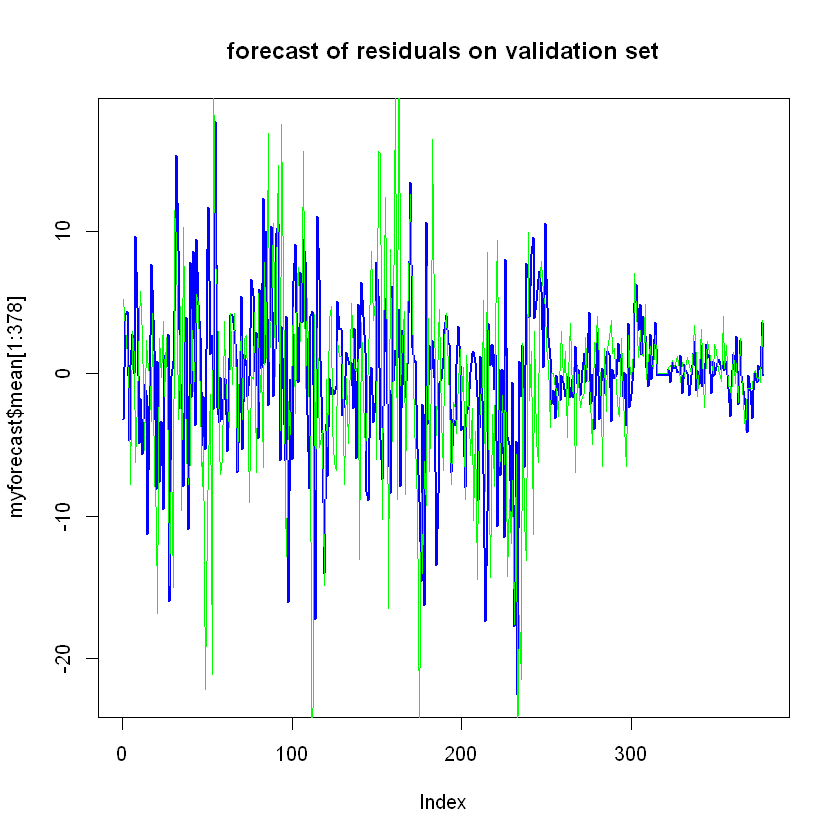

In [55]:
plot(myforecast$mean[1:378],type='l',main='forecast of residuals on validation set',col='blue',lwd=2)
lines(residvalid,col='green',lwd=1)

In [41]:
new.predicted.demand<-final.model[883:1323]-myforecast$mean

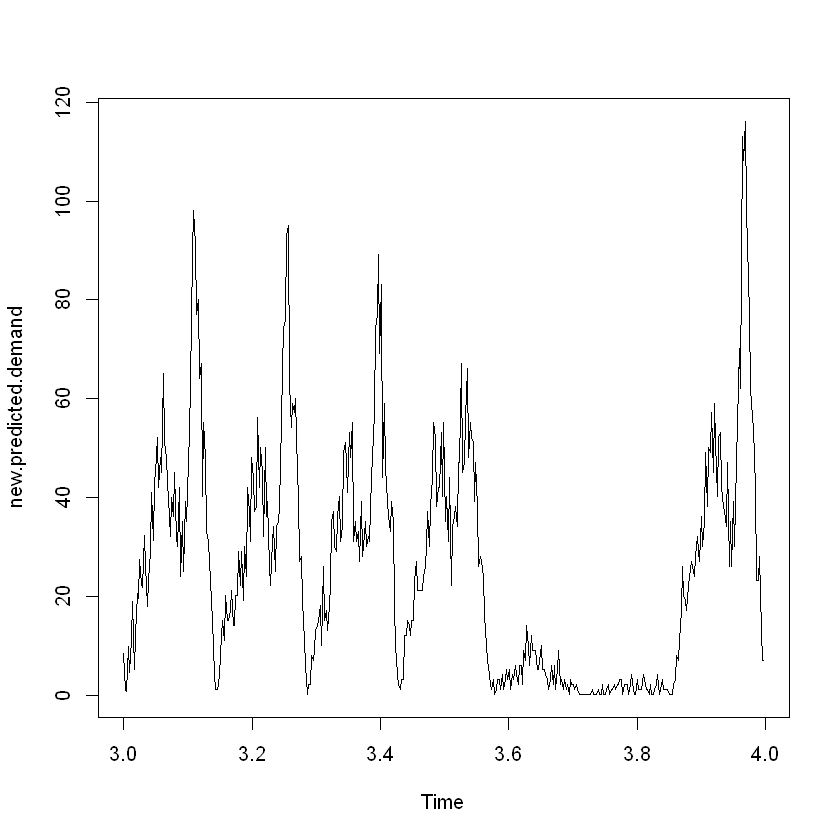

In [37]:
plot(new.predicted.demand)

In [42]:
#NEW R SQUARED

actual.demand<-validation.set$demand
predicted.demand<-new.predicted.demand

residuals<-actual.demand-predicted.demand


#Adjusted R-Squared
n=length(actual.demand)
k=dim(new.final.model.data)[2]-1 #Subtract one to ignore intercept
SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
R2.final<- 1-(SSE/SSyy)*(n-1)/(n-(k+1))

cat('final adjusted R squared on validation set = ',R2.final,'\n\n')

final adjusted R squared on validation set =  0.7139175 



In [43]:
final.model[883:1323]<-new.predicted.demand


#new MAE
comparisondata<-data.frame(newdata$date.and.time,newdata$demand,round(final.model),newdata$demand-round(final.model),newdata$daytype,newdata$myseason)
colnames(comparisondata)<-c('date.and.time','demand','predicted','residual','daytype','season')

comparison.validation<-data.frame(comparisondata[883:1323,],
        abs((comparisondata$demand-comparisondata$predicted)/comparisondata$demand*100)[883:1323],
        abs(comparisondata$demand-comparisondata$predicted)[883:1323])

colnames(comparison.validation)<-c(colnames(comparison.validation)[1:6],'APE','AE')

#fix for 0 demand values
comparison.validation$APE[comparison.validation$demand==0]<- abs(comparison.validation$predicted[comparison.validation$demand==0])/0.5*100
head(comparison.validation)

MAPE<-mean(comparison.validation$APE)
cat('MAPE=',MAPE,'\n')
MAE=mean(comparison.validation$AE)
cat('MAE=',MAE)

,date.and.time,demand,predicted,residual,daytype,season,APE,AE
883,2005-03-15 06:30:00,0,8,-8,weekday,1,1600.00000,8
884,2005-03-15 06:45:00,2,1,1,weekday,2,50.00000,1
885,2005-03-15 07:00:00,4,1,3,weekday,3,75.00000,3
886,2005-03-15 07:15:00,7,10,-3,weekday,4,42.85714,3
887,2005-03-15 07:30:00,13,5,8,weekday,5,61.53846,8
888,2005-03-15 07:45:00,11,11,0,weekday,6,0.00000,0


MAPE= 178.2039 
MAE= 5.99093

## Maybe tbats residuals?


In [51]:
multiple<-msts(residseries, seasonal.periods=c(63,7*63))
frequency(multiple)

[1] 441

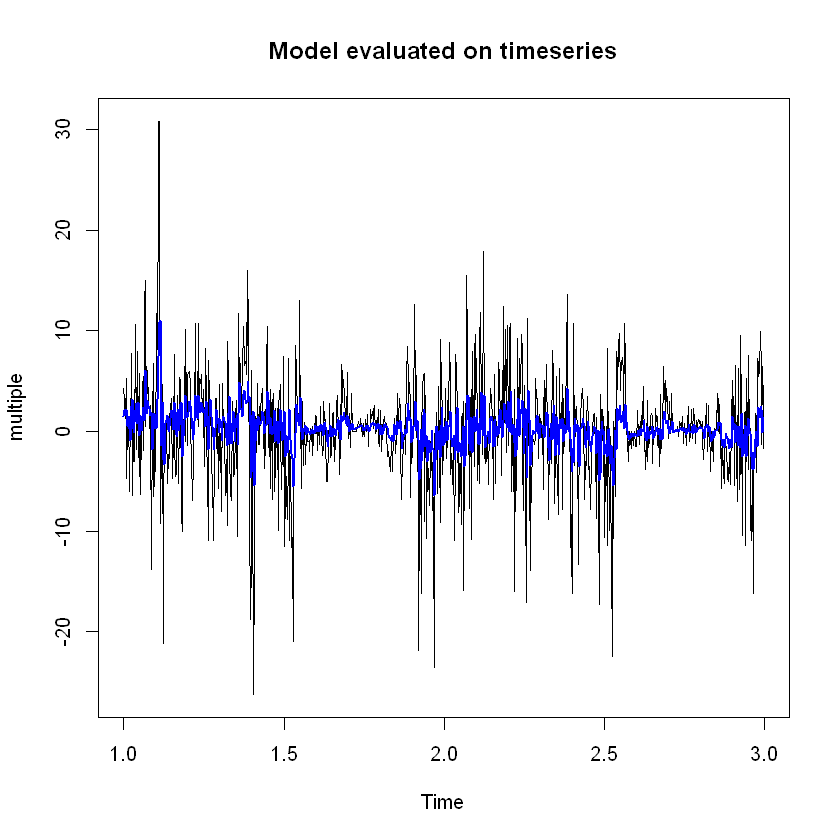

In [54]:
model<-tbats(multiple,seasonal.periods=c(63,7*63))

#coefficients(model)
coef<-coefficients(model)
plot(multiple,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

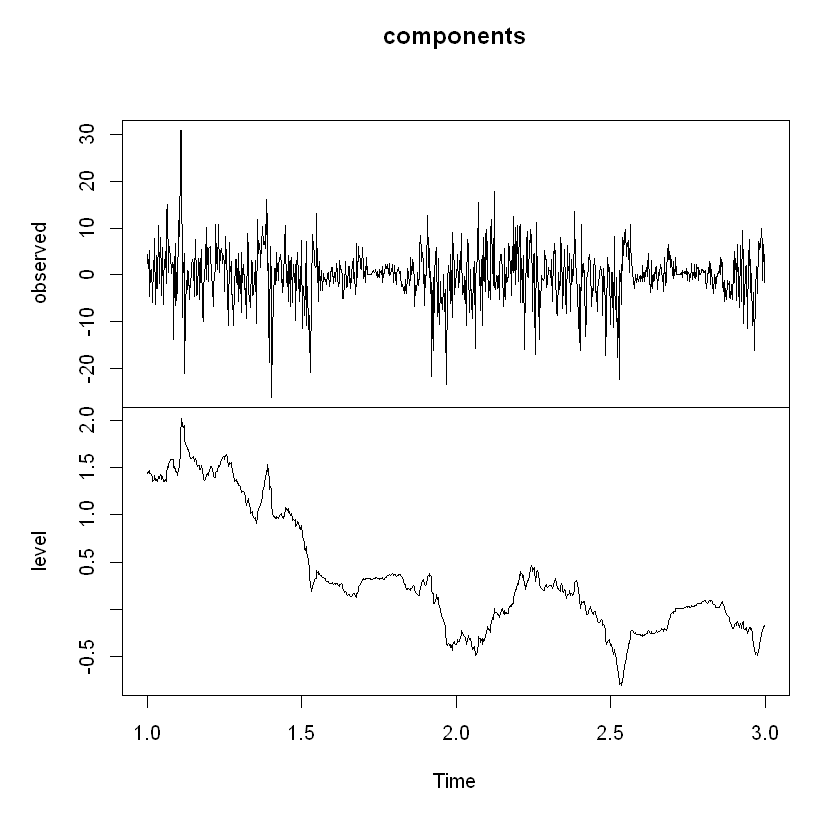

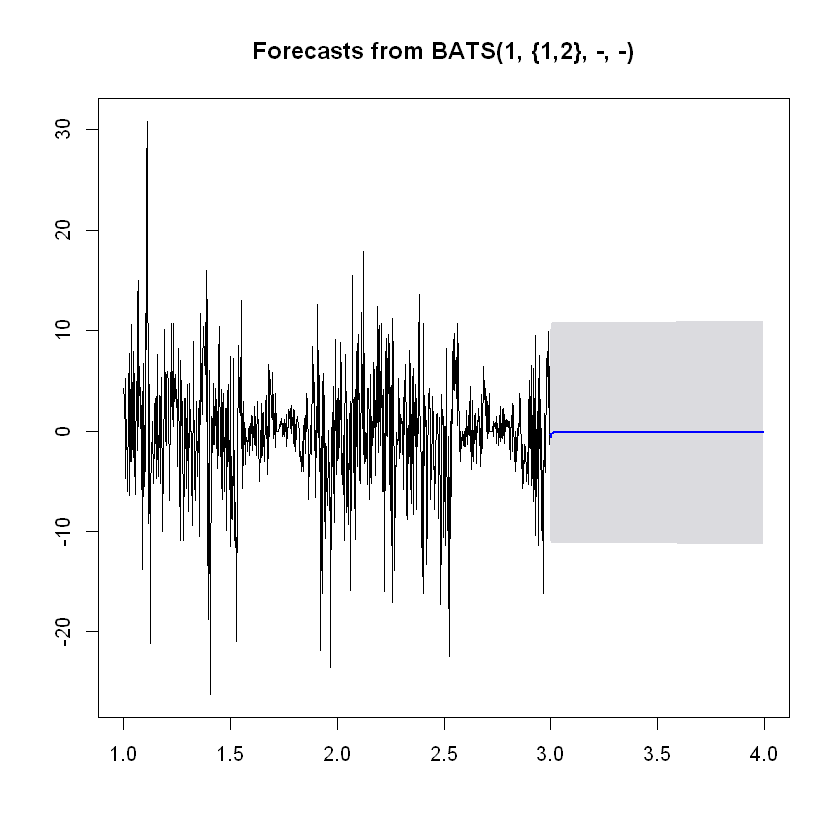

In [56]:
components <- tbats.components(model)
plot(components)

myforecast<-forecast(model,h=63*7,level = c(95))
plot(myforecast)

All in all,it looks like integrating residual forecasts to our model makes it's predictions worse.We interpret this as such.Our model captures the underlying structure of the data very well so there is no useful information left in the model's residuals.

# Fitting the model to the entire period to produce forecasts

In [24]:
totaltrainingdata<-new.model.data[1:1323,]
newmodel<-lm(demand~.,totaltrainingdata)
summary(newmodel)


Call:
lm(formula = demand ~ ., data = totaltrainingdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-78.302  -2.875  -0.167   2.855  37.400 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     8.9355     1.1234   7.954 4.16e-15 ***
daytype        -3.2065     0.5818  -5.511 4.36e-08 ***
S6             11.5701     3.7287   3.103 0.001961 ** 
S7             17.9987     3.7287   4.827 1.57e-06 ***
S8             14.9145     3.3993   4.388 1.25e-05 ***
S9             12.4060     2.4288   5.108 3.79e-07 ***
S10            13.1811     3.3993   3.878 0.000111 ***
S11            13.6654     3.7287   3.665 0.000258 ***
S12            17.8527     2.4288   7.350 3.66e-13 ***
S13            17.7901     2.4288   7.325 4.40e-13 ***
S14            17.9821     2.4288   7.404 2.50e-13 ***
S15            16.5621     2.4288   6.819 1.45e-11 ***
S16            21.0227     2.4288   8.655  < 2e-16 ***
S17            22.7278     2.4288   9.358  < 2e-16 ***
S18     

In [25]:
#We create a new dataframe to make the model calculation easier below
ones<-rep(1,1512)
#we remove the demand column since thats what we predict and we replace it with ones
#so they are multiplied by the intercept coefficient
new.final.model.data<-data.frame(ones,new.model.data[,-1])


#coefficients(model)
newcoef<-coefficients(newmodel)

newmymodel = rowSums(mapply("*", as.data.frame(new.final.model.data),newcoef))

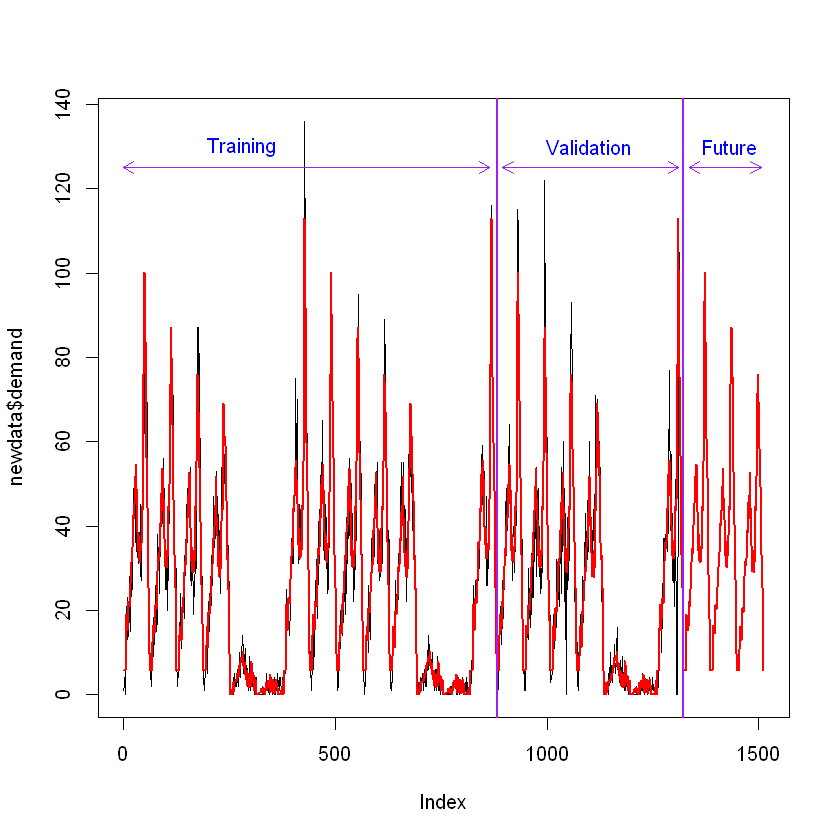

In [26]:
#replace negative values with 0
final.model<-newmymodel
final.model[which(newmymodel<0)]<-0


plot(newdata$demand,type='l')
lines(final.model,lwd = 2,col='red')

lines(c(882, 882), c(-20, 200),col='purple',lwd=2)
lines(c(1323, 1323), c(-20, 200),col='purple',lwd=2)
text(280, 130, "Training",col='blue')
text(1100, 130, "Validation",col='blue')
text(1430, 130, "Future",col='blue')
arrows(0 , 125, 865, 125, code = 3, length = 0.1, lwd = 1,angle = 30,col='purple')
arrows(895, 125, 1310, 125, code = 3, length = 0.1, lwd = 1,angle = 30,col='purple')
arrows(1335, 125, 1505, 125, code = 3, length = 0.1, lwd = 1, angle = 30,col='purple')

In [103]:
#write predictions to future set
future.set$demand<-round(final.model[1324:1512])
head(future.set[1:2],20)

,date.and.time,demand
1324,2005-03-22 06:30:00,6
1325,2005-03-22 06:45:00,6
1326,2005-03-22 07:00:00,6
1327,2005-03-22 07:15:00,6
1328,2005-03-22 07:30:00,6
1329,2005-03-22 07:45:00,14
1330,2005-03-22 08:00:00,19
1331,2005-03-22 08:15:00,16
1332,2005-03-22 08:30:00,17
1333,2005-03-22 08:45:00,15


# Links

http://www-ist.massey.ac.nz/dstirlin/CAST/CAST/Hmultiplicative/multiplicative3.html

https://www.quora.com/Why-do-we-remove-the-predictor-with-P-value-greater-than-significance-level-P-significance-level-denotes-that-we-cannot-reject-the-null-hypothesis